In [12]:
import seaborn as sns
import csv
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from json import loads
import pandas as pd
from pytz import timezone

In [13]:
%matplotlib notebook

def connect_kafka_consumer(topic):
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, 
                                   auto_offset_reset='latest', 
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 10
        height = 6
        fig = plt.figure(figsize=(width,height)) 
        ax = fig.add_subplot(111) 
        ax.set_xlabel('Time')
        ax.set_ylabel('Counts')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() 
        fig.canvas.draw() 
        return fig, ax
    except Exception as ex:
        print(str(ex))     

%matplotlib notebook

def consume_messages(consumer,fig,ax):
    try:
        print('waiting for messages')
        msg = pd.DataFrame()
        for message in consumer:
            data = pd.DataFrame(message.value)
            data['p_ts']=int(dt.datetime.now(timezone('UTC')).timestamp())   
            msg = msg.append(data)
            
            
            t_0 = dt.datetime.utcfromtimestamp(int(list(msg['p_ts'])[0])).strftime('%M')
            t_1 = dt.datetime.utcfromtimestamp(int(list(msg['p_ts'])[-1])).strftime('%M')
               

            if True:
                ax.clear()
                temp = msg.groupby(['machine','p_ts']).count().reset_index()
                for i in range(0,len(temp)):
                    temp.loc[i,'p_ts'] = str(dt.datetime.utcfromtimestamp(int(temp.loc[i,'p_ts'])).strftime('%H:%M:%S'))
                 
                
                mach4 = temp[temp['machine']=='4']
                mach5 = temp[temp['machine']=='5']
                mach6 = temp[temp['machine']=='6']
                mach7 = temp[temp['machine']=='7']
                mach8 = temp[temp['machine']=='8']
                plt.plot(mach4['p_ts'],mach4['sequence'], label = '4', c='blue')
                plt.plot(mach5['p_ts'],mach5['sequence'], label = '5', c='green')
                plt.plot(mach6['p_ts'],mach6['sequence'], label = '6', c='black')
                plt.plot(mach7['p_ts'],mach7['sequence'], label = '7', c='red')
                plt.plot(mach8['p_ts'],mach8['sequence'], label = '8', c='purple')
                plt.xticks(rotation=45)
              

                ax.set_title("Memory Count Streaming")
                ax.set_xlabel("Processing_Time_Memory")
                ax.set_ylabel("Count_defined")
                ax.legend()
                fig.show()
                fig.canvas.draw()
                if abs(int(t_1)-int(t_0)) >= 2:
                    msg = msg[msg['ts'] !=list(msg['ts'])[0]].copy()
        plt.close('all')

    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


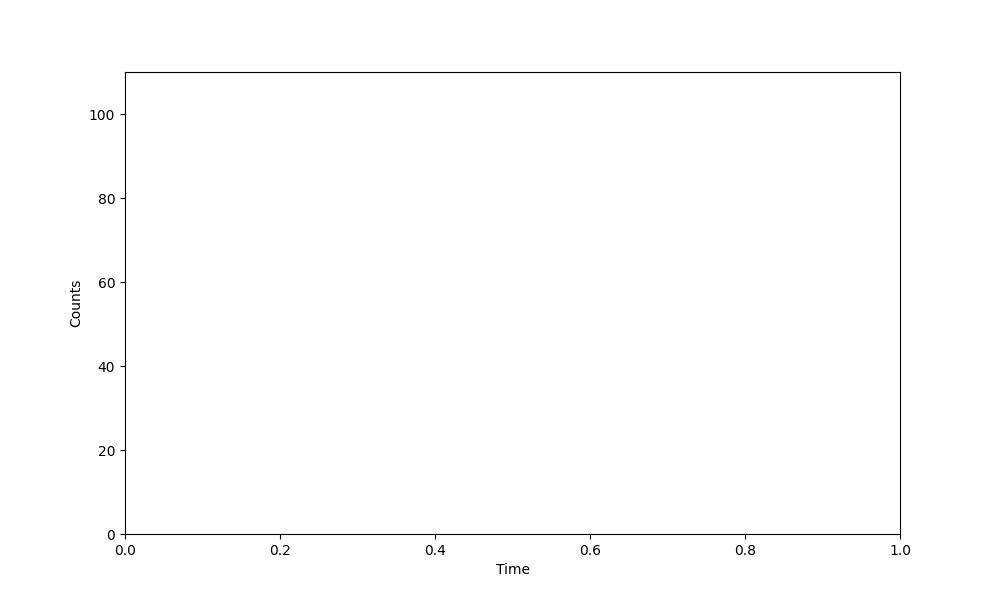

waiting for messages


In [14]:
if __name__ == '__main__':
    topic = 'memory'
    consumer = connect_kafka_consumer(topic)
    
    fig, ax = init_plots()
    consume_messages(consumer, fig,ax)